In [1]:
import os
import shutil
import matplotlib.pyplot as plt
original_dataset_dir = './img'   
classes_list = os.listdir(original_dataset_dir) 

train_dir = './img/'
classes = ["classic", "modern", "natural", "northern", "unique", "vintage"]



base_dir = './splitted' 
# os.mkdir(base_dir)
 
train_dir = os.path.join(base_dir, 'train') 
# os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'val')
# os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)

# for cls in classes_list:     
#     os.mkdir(os.path.join(train_dir, cls))
#     os.mkdir(os.path.join(validation_dir, cls))
#     os.mkdir(os.path.join(test_dir, cls))

In [2]:
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
 
    train_size = math.floor(len(fnames) * 0.8)
    validation_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( classic ):  60
Validation size( classic ):  15
Train size( modern ):  167
Validation size( modern ):  41
Train size( natural ):  110
Validation size( natural ):  27
Train size( northern ):  75
Validation size( northern ):  18
Train size( unique ):  168
Validation size( unique ):  42
Train size( vintage ):  86
Validation size( vintage ):  21


In [3]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# DEVICE = torch.device("cpu")
BATCH_SIZE = 256 
EPOCH = 200 

In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
 
transform_base = transforms.Compose([transforms.Resize((64,64)), 
                                     transforms.ToTensor(),]) 
train_dataset = ImageFolder(root='./splitted/train', transform=transform_base) 
val_dataset = ImageFolder(root='./splitted/val', transform=transform_base)

In [5]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DeepImageClassifier(nn.Module):
    def __init__(self):
        super(DeepImageClassifier, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)

        # Max pooling layers
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 6)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = x.view(-1, 4096)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        # x = F.relu(x)
        # x = self.dropout2(x)

        return F.log_softmax(x,dim=1)

model_base = DeepImageClassifier().to(DEVICE)
optimizer = optim.Adam(model_base.parameters(), lr=0.001) 

In [7]:
from torchsummary import summary

summary(model_base, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
         MaxPool2d-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 32, 32]          73,856
         MaxPool2d-4          [-1, 128, 16, 16]               0
            Conv2d-5          [-1, 256, 16, 16]         295,168
         MaxPool2d-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 512, 8, 8]       1,180,160
         MaxPool2d-8            [-1, 512, 4, 4]               0
            Conv2d-9           [-1, 1024, 4, 4]       4,719,616
        MaxPool2d-10           [-1, 1024, 2, 2]               0
           Linear-11                 [-1, 1024]       4,195,328
          Dropout-12                 [-1, 1024]               0
           Linear-13                    [-1, 6]           6,150
Total params: 10,472,070
Trainable para

In [8]:
def train(model, train_loader, optimizer):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) 
        
        optimizer.zero_grad() 
        output = model(data)  
        loss = F.cross_entropy(output, target) 
        loss.backward()  
        optimizer.step()  

In [9]:
def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE)  
            output = model(data) 
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

In [10]:
import time
import copy
t_loss = []
t_acc = []

v_loss = []
v_acc = []
def train_baseline(model ,train_loader, optimizer, num_epochs = 30):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        val_loss, val_acc = evaluate(model, val_loader)
        
        if val_acc > best_acc:
            best_acc = train_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts,f'./dict/baseline_{epoch}.pt')
            
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        t_loss.append(train_loss)
        t_acc.append(train_acc)
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        v_loss.append(val_loss)
        v_acc.append(val_acc)
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    model.load_state_dict(best_model_wts)  
    return model
 

base = train_baseline(model_base, train_loader, optimizer, 1000)  	 #(16)
torch.save(base.state_dict(),'./dict/baseline.pt')


-------------- epoch 1 ----------------
train Loss: 1.7879, Accuracy: 16.52%
val Loss: 1.7878, Accuracy: 16.46%
Completed in 0m 29s
-------------- epoch 2 ----------------
train Loss: 1.7459, Accuracy: 25.23%
val Loss: 1.7447, Accuracy: 25.61%
Completed in 0m 27s
-------------- epoch 3 ----------------
train Loss: 1.7159, Accuracy: 25.23%
val Loss: 1.7160, Accuracy: 25.61%
Completed in 0m 27s
-------------- epoch 4 ----------------
train Loss: 1.7154, Accuracy: 25.08%
val Loss: 1.7183, Accuracy: 25.00%
Completed in 0m 28s
-------------- epoch 5 ----------------
train Loss: 1.7178, Accuracy: 25.08%
val Loss: 1.7290, Accuracy: 25.00%
Completed in 0m 27s
-------------- epoch 6 ----------------
train Loss: 1.6997, Accuracy: 30.93%
val Loss: 1.7077, Accuracy: 25.61%
Completed in 0m 27s
-------------- epoch 7 ----------------
train Loss: 1.6892, Accuracy: 27.18%
val Loss: 1.7028, Accuracy: 25.00%
Completed in 0m 27s
-------------- epoch 8 ----------------
train Loss: 1.6658, Accuracy: 26.88%

KeyboardInterrupt: 

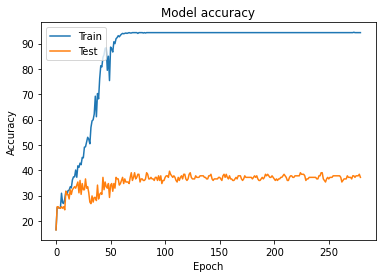

In [11]:
import matplotlib.pyplot as plt

plt.plot(t_acc)
plt.plot(v_acc)
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

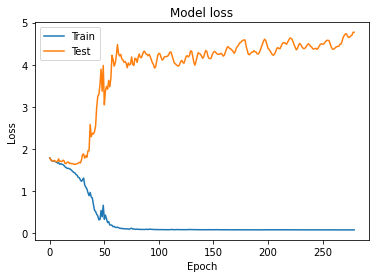

In [12]:
plt.plot(t_loss)
plt.plot(v_loss)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Inference

In [13]:
from PIL import Image
image_name = 'modern_2.jpg'
transform_base = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor()])
image_path = f"D:/junyoung/4-1/AIcapstone/RoomSketcher/test/{image_name}"
test_base = (transform_base(Image.open(image_path))).to(DEVICE)
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

unique


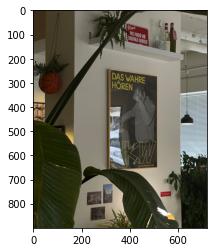

In [14]:
base=DeepImageClassifier().to(DEVICE)

baseline=torch.load('D:/junyoung/4-1/AIcapstone/RoomSketcher/dict/baseline.pt') 
base.load_state_dict(baseline)
base.eval()  
result = base(test_base.unsqueeze(0)).to(DEVICE)

image = plt.imread(f"D:/junyoung/4-1/AIcapstone/RoomSketcher/test/{image_name}")
plt.imshow(image)
print(classes[torch.argmax(result)])
# print('baseline test acc:  ', test_accuracy)

In [14]:
base = Net().to(DEVICE)

In [ ]:
from PIL import Image
image_name = 'classic_10.jpg'
transform_base = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor()])
image_path = f"D:/junyoung/4-1/AIcapstone/RoomSketcher/test/{image_name}"
test_base = (transform_base(Image.open(image_path))).to(DEVICE)
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)



baseline=torch.load('D:/junyoung/4-1/AIcapstone/RoomSketcher/baseline_57.pt') 
base.load_state_dict(baseline)
base.eval()  
result = base(test_base.unsqueeze(0)).to(DEVICE)

image = plt.imread(f"D:/junyoung/4-1/AIcapstone/RoomSketcher/test/{image_name}")
plt.imshow(image)
print(classes[torch.argmax(result)])